In [1]:
# import libraries
from dotenv import load_dotenv
load_dotenv('.env')
from libs.neo4j_functions import run_query

In [2]:
from sentence_transformers import SentenceTransformer



sentence_transformers_model = SentenceTransformer("all-MiniLM-L6-v2")

node_texts = run_query("match (p:Product) where p.textEmbededding is NULL return p.name as node_text")





/home/manoj/Github/agent_rag_tools/venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: textEmbededding)} {position: line: 1, column: 27, offset: 26} for query: 'match (p:Product) where p.textEmbededding is NULL return p.name as node_text'


In [3]:
if len(node_texts) >1:
      sentences = [n['node_text'] for n in node_texts]
      sentences = [s if s is not None else "No Product name" for s in sentences]
      sentences_embeddings = sentence_transformers_model.encode(sentences)
      for sentence, sentences_embed in zip(sentences, sentences_embeddings):
            run_query("""MATCH (p:Product) WHERE p.textEmbedding IS NULL and p.name = $chunkText set p.textEmbedding = $ChunkEmbTextparam""", params={'chunkText': sentence, 'ChunkEmbTextparam': sentences_embed.tolist() })


In [4]:
VECTORY_SEARCH_QUERY = """
// find products by similarity search in vector index
CALL db.index.vector.queryNodes($index_name, 10, $embedding) yield node as product, score

MATCH (product)<-[:BOUGHT]-(c:Customer)-[:WROTE]->(r:Review)
RETURN product.name, collect (r.text)[0..5] as reviews
"""

# // enrich with additional explicit relationships from the knowledge graph
# MATCH (product)-[:HAS_CATEGORY]->(cat), (product)-[:BY_BRAND]->(brand)

# OPTIONAL MATCH (product)<-[:BOUGHT]-(customer)-[WROTE:RATED]->(product) 
#          WHERE rated.rating = 5
# OPTIONAL MATCH (product)-[:HAS_REVIEW]->(review)<-[:WROTE]-(customer) 

# RETURN product.Name, product.Description, brand.Name, cat.Name, 
#        collect(review { .Date, .Text })[0..5] as reviews

In [5]:
def return_context(prompt):
    prompt_embedded = sentence_transformers_model.encode(prompt)
    response = run_query(VECTORY_SEARCH_QUERY, params={"embedding": prompt_embedded, 'index_name':'product_index'})
    return '\n'.join(
            [
            f'Product: {each.get("product.name")}. '
            + 'Review: ' 
            + '. '.join([s.replace('r.', '') for s in each.get('reviews')]) 
            + '.'
            for each in response
            ]
        )

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    context: str

In [18]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions, convert_to_ollama_tool
from libs.tool_def import get_metric_values, get_unique_dimension_values, get_available_columns
from langchain_core.output_parsers import JsonOutputParser
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.messages import AIMessage
import os

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        # while True:
        configuration = config.get("configurable", {})
        # passenger_id = configuration.get("passenger_id", None)
        # state = {**state, "user_info": passenger_id}
        
        # print_messages(state,'ASSISTANT')
        result = self.runnable.invoke(state)
        
        # If the LLM happens to return an empty response, we will re-prompt it
        # for an actual response.
        # if not result.tool_calls and (
        #     not result.content
        #     or isinstance(result.content, list)
        #     and not result.content[0].get("text")
        # ):
        #     messages = state["messages"] + [("user", "Respond with a real output.")]
        #     state = {**state, "messages": messages}
        # else:
        #     break
        return {"messages": result}


from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# OLLAMA FUNCTION DOES not working (loops infinitely)
# llm = OllamaFunctions(
#     model="llama3-groq-tool-use:latest", 
#     base_url='http://localhost:11434',
#     format='json'
#     )

# OLLAMA FUNCTIONS SERVED USING LITELLM PROXY not working (loops infinitely)
# llm = ChatOpenAI(model="something", base_url="http://localhost:4000/v1", api_key="llama3", temperature=0, stop_sequences=["response"])

# USING OPENAI with openai's model, THE WHOLE THING WORKS
# llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv('OPENAI_API_KEY'))   

# USING OPENAI WITH local model and using LITELLM, the agents get the answer, but does not stop
# llm = ChatOpenAI(model="llama3-groq-tool-use:latest", base_url="http://localhost:4000/v1", api_key="ollama")


# USING CHATOLLAMA (use env variable OLLAMA_HOST=http://127.0.0.1:11434), THIS WORKS as well, but only on ovh hardware, not on local RTX
llm = ChatOllama(model="llama3.1:8b-instruct-fp16", temperature=0)
# llm = ChatOllama(model="llama3-groq-tool-use", temperature=0)


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that answers user question only based on the context."
            # "You have access to three tools: get_unique_dimension_values, get_metric_values, get_available_columns."
            # "For any question related to getting unique columns, metric values or available columns, use the provided tools to answer questions."
            # "Never make up your own answers based on your knowledge. Base all your answers from tool messages."
            # " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            # " If a search comes up empty, expand your search before giving up."
            # " If you have a response from a tool that answers the question, generate the final answer"
            # "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())



part_1_assistant_runnable =  primary_assistant_prompt | llm

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

   
builder = StateGraph(State)


# Define nodes: these do the work
# builder.add_node("first_agent", first_agent)
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

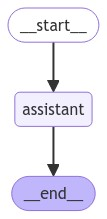

In [20]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
def _print_event(event: dict, _printed: set, max_length=1500):
    print(event)
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [24]:
import uuid
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
    },
}


_printed = set()
question = "which shaving razer do you recommend for a young male?"
# question = "What are the unique values of protocols dimension from procedures table?"
events = part_1_graph.stream(
    {"messages": ('user', f'you have this context: {str(return_context(question))}. Question:'+question)}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

{'messages': [HumanMessage(content='you have this context: Product: Philips Norelco 7610X Quadra7 Men\'s Shaving System. Review: This is a very good and basic shaver without all of the extras. It shaves as close as the more expensive models but does not have all of the bells and whistles. My biggest complaint is that you can not shave while it is charging, which I think is a major flaw. Overall I like it and for the money I am very satisfied with it.\', rating = 4.0, summary = \'Good deal for the money.. Have had this shaving system for nearly 3 weeks. Enjoying the convenience and it seems to do the job. Too good to last but Amazon wants a review now.\', rating = 4.0, summary = \'Good bargain. How long will it last?. As always I get excellent shaves with Norelco. My only complaint would be their continued use of NiCad batteries. If they would switch to NiMH I wouldn\'t have to run the batteries down before recharging them, which can be inconvenient.\', rating = 4.0, summary = \'excelle